In [1]:
import torch
import numpy as np

In [2]:
grid_feature_path = "outputs/ecb91f433f144a7798724890f0528b23/f3rm/2025-03-24_235407/clip_features_features.npy"
grid_feature = np.load(grid_feature_path)
grid_feature.shape

(200, 200, 225, 768)

In [3]:
from f3rm.pca_colormap import apply_pca_colormap_return_proj, apply_pca_colormap

In [4]:
device="cuda"
grid_feature = torch.from_numpy(grid_feature).to(device).float()

/home/vlongle/miniconda3/envs/f3rm/lib/python3.8/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
import trimesh
ply_path = "outputs/ecb91f433f144a7798724890f0528b23/f3rm/2025-03-24_235407/pc.ply"
pc = trimesh.load(ply_path)
print("number of vertices: ", pc.vertices.shape)

number of vertices:  (54888, 3)


In [6]:
vertices = pc.vertices
print("Vertices shape:", vertices.shape)

# Convert world coordinates to grid indices
min_bounds = np.array([-1., -1., -2.])
max_bounds = np.array([1., 1., 0.25])
grid_shape = np.array([200, 200, 225])
voxel_size = (max_bounds - min_bounds) / grid_shape

# Convert vertices to grid indices
grid_indices = np.floor((vertices - min_bounds) / voxel_size).astype(int)

# Filter out any indices that might be out of bounds
valid_mask = np.all((grid_indices >= 0) & (grid_indices < grid_shape), axis=1)
grid_indices = grid_indices[valid_mask]

# Get unique indices to avoid duplicates
unique_indices = np.unique(grid_indices, axis=0)
print("Number of unique occupied voxels:", unique_indices.shape[0])


Vertices shape: (54888, 3)
Number of unique occupied voxels: 54666


In [7]:
rbg_colors = pc.colors

## filter to the unique indices
rbg_colors = rbg_colors[valid_mask]

In [8]:
occupied_features = []
for idx in unique_indices:
    i, j, k = idx
    occupied_features.append(grid_feature[i, j, k].cpu().numpy())
    
occupied_features = torch.tensor(occupied_features).to(device).float()


/tmp/ipykernel_804134/577486745.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  occupied_features = torch.tensor(occupied_features).to(device).float()


In [9]:
from f3rm.pca_colormap import apply_pca_colormap

# This function should be modified to work on a list of features rather than the full grid
pca_colors = apply_pca_colormap(occupied_features, niter=10)
print("PCA colors shape:", pca_colors.shape)


torch.Size([54666, 768])
finished computing proj_V:  torch.Size([768, 3])
finished computing low_rank:  torch.Size([54666, 3])
finished computing colored_image:  torch.Size([54666, 3])
PCA colors shape: torch.Size([54666, 3])


In [10]:
pca_colors = pca_colors.cpu().numpy()

In [11]:
pca_colors

array([[0.15424074, 0.02055958, 0.2948936 ],
       [0.1262027 , 0.03683121, 0.31967476],
       [0.13750517, 0.09607547, 0.3198648 ],
       ...,
       [0.07601034, 0.06595468, 0.38390926],
       [0.07272281, 0.10581775, 0.384036  ],
       [0.08107536, 0.10231943, 0.38202667]], dtype=float32)

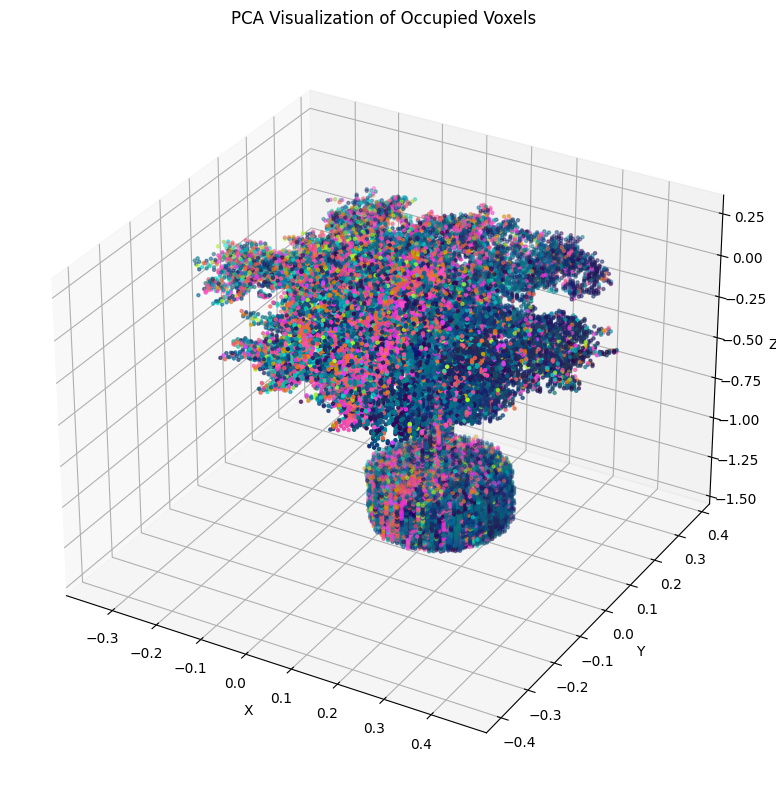

In [12]:
import matplotlib.pyplot as plt
# Visualize a subset of points (for faster rendering)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Sample points for visualization (e.g., every 10th point)
sample_step = 10
sample_points = vertices[valid_mask]
sample_colors = pca_colors
# sample_colors = rbg_colors

if sample_colors.max() > 1.0:
    sample_colors = sample_colors / 255.0

ax.scatter(
    sample_points[:, 0], 
    sample_points[:, 1], 
    sample_points[:, 2],
    c=sample_colors, 
    s=5
)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('PCA Visualization of Occupied Voxels')
plt.tight_layout()
plt.show()